## MindLens-AI -- Notebook 01: Exploratory Data Analysis

Exploring the Reddit Mental Health Dataset (RMHD) before building any models. The goal here is to understand class balance, text length distributions, and which terms appear most frequently in each class.

### Dataset Acquisition

| Property | Details |
|----------|---------|
| Dataset | Reddit Mental Health Dataset (RMHD) |
| Source | Original Reddit Data (multi-subreddit, 2019–2022) |
| Raw Size | ~1.85 million posts across 5 subreddits |
| Subreddits | r/depression, r/SuicideWatch, r/Anxiety, r/lonely, r/mentalhealth |
| Sampled Size | 20,000 posts (10K per class, configurable) |
| Labels | Binary — 0 = Control, 1 = Risk (assigned by subreddit) |
| Domain | Mental health / NLP text classification |
| Format | CSV files organised by year and month |

### Binary Label Construction

Since RMHD is a multi-class dataset (posts from different mental-health subreddits), we **construct** a binary classification target:

| Subreddit | Binary Label | Rationale |
|-----------|-------------|-----------|
| r/depression | 1 (Risk) | High-risk mental health community — posts expressing depressive episodes |
| r/SuicideWatch | 1 (Risk) | High-risk mental health community — posts indicating suicidal ideation or crisis |
| r/Anxiety | 0 (Control) | General mental health discussion community |
| r/lonely | 0 (Control) | General mental health discussion community |
| r/mentalhealth | 0 (Control) | General mental health discussion community |

**Limitation:** Subreddit-based labeling may introduce contextual bias, which is evaluated through bias and robustness analysis in later stages.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from src.preprocessing import load_rmhd_dataset, preprocess_pipeline, save_processed
from src.features import build_tfidf

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

print("Setup done.")

Setup done.


## 1. Load and Preprocess

In [2]:
raw_df = load_rmhd_dataset(
    data_dir="../data/raw/Original Reddit Data/raw data",
    sample_per_class=10_000,
    random_state=42,
)
print(f"Raw dataset: {raw_df.shape[0]} rows, {raw_df.shape[1]} cols")
print(raw_df["label"].value_counts())
print("\nSubreddit breakdown:")
print(raw_df["subreddit"].value_counts())

df = preprocess_pipeline(raw_df, remove_stopwords=False)
print(f"\nAfter cleaning: {df.shape[0]} rows")
df.head()

RMHD loaded: 20000 rows  |  label distribution:
{1: 10000, 0: 10000}
Raw dataset: 20000 rows, 3 cols
label
1    10000
0    10000
Name: count, dtype: int64

Subreddit breakdown:
subreddit
depression      5661
SuicideWatch    4339
mentalhealth    4107
Anxiety         3803
lonely          2090
Name: count, dtype: int64

After cleaning: 19956 rows


,text,label,subreddit,word_count,char_count,avg_word_length,word_density,unique_word_ratio
0,i ve decided to sleep until i die every method...,1,SuicideWatch,32,165,5.156250,0.193939,0.875000
1,what to do when you don t feel any happiness o...,1,depression,432,1988,4.601852,0.217304,0.418981
2,i don t know what to do anymore so i m not gon...,1,SuicideWatch,182,855,4.697802,0.212865,0.560440
3,each day is getting worse at the moment i neve...,1,depression,149,713,4.785235,0.208976,0.590604
4,update i ve told in my other post that i told ...,1,SuicideWatch,311,1468,4.720257,0.211853,0.495177


## 2. Quick Overview

In [3]:
print("Shape:", df.shape)
print("\n--- Info ---")
df.info()
print("\n--- Describe ---")
df.describe()

Shape: (19956, 8)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19956 entries, 0 to 19955
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               19956 non-null  object 
 1   label              19956 non-null  int64  
 2   subreddit          19956 non-null  object 
 3   word_count         19956 non-null  int64  
 4   char_count         19956 non-null  int64  
 5   avg_word_length    19956 non-null  float64
 6   word_density       19956 non-null  float64
 7   unique_word_ratio  19956 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.2+ MB

--- Describe ---


,label,word_count,char_count,avg_word_length,word_density,unique_word_ratio
count,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000,19956.000000
mean,0.500301,167.605282,819.489076,4.988292,0.204265,0.681791
std,0.500012,214.029596,1054.098413,5.741657,0.018675,0.168826
min,0.000000,1.000000,2.000000,2.000000,0.001240,0.011765
25%,0.000000,45.000000,217.000000,4.666667,0.196106,0.558421
50%,1.000000,108.000000,525.000000,4.869758,0.205349,0.659091
75%,1.000000,213.000000,1036.000000,5.099291,0.214286,0.791667
max,1.000000,6468.000000,31001.000000,806.500000,0.500000,1.000000


## 2b. Data Quality Assessment

In [4]:
# Missing values
print("Missing values:\n", raw_df[["text", "label"]].isnull().sum())

# Duplicates
n_dupes = raw_df.duplicated(subset=["text"]).sum()
print(f"\nDuplicates in raw data: {n_dupes} (removed by pipeline)")

# Subreddit composition
print("\nSubreddit composition (before cleaning):")
for sub in raw_df["subreddit"].unique():
    n = (raw_df["subreddit"] == sub).sum()
    lab = 1 if sub in {"depression", "SuicideWatch"} else 0
    print(f"  {sub}: {n} posts -> label {lab}")

# Outliers (word count, IQR)
Q1, Q3 = df["word_count"].quantile(0.25), df["word_count"].quantile(0.75)
upper = Q3 + 1.5 * (Q3 - Q1)
n_outliers = (df["word_count"] > upper).sum()
print(f"\nWord-count outliers (>{upper:.0f}): {n_outliers} ({n_outliers/len(df)*100:.1f}%) — long posts, retained")

Missing values:
 text     0
label    0
dtype: int64

Duplicates in raw data: 29 (removed by pipeline)

Subreddit composition (before cleaning):
  SuicideWatch: 4339 posts -> label 1
  depression: 5661 posts -> label 1
  mentalhealth: 4107 posts -> label 0
  Anxiety: 3803 posts -> label 0
  lonely: 2090 posts -> label 0

Word-count outliers (>465): 1285 (6.4%) — long posts, retained


## 3. Class Distribution

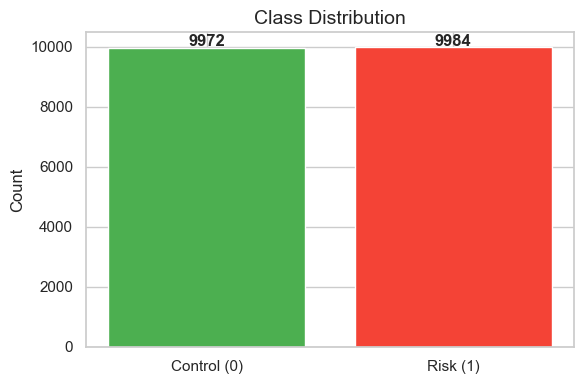

Class balance -- Control: 9972 (50.0%)  |  Risk: 9984 (50.0%)


In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
counts = df["label"].value_counts().sort_index()
bars = ax.bar(["Control (0)", "Risk (1)"], counts.values, color=["#4CAF50", "#F44336"])
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            str(val), ha="center", fontweight="bold")
ax.set_title("Class Distribution", fontsize=14)
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

ratio_0 = counts[0] / len(df) * 100
ratio_1 = counts[1] / len(df) * 100
print(f"Class balance -- Control: {counts[0]} ({ratio_0:.1f}%)  |  Risk: {counts[1]} ({ratio_1:.1f}%)")

**Imbalance Assessment:** The dataset is balanced by construction (equal sampling per class). Standard stratified train/test splits will preserve the ratio. No need for SMOTE, class-weighted loss, or undersampling beyond the initial balancing step.

## 3b. Post Distribution by Subreddit

C:\Users\Kartik\AppData\Local\Temp\ipykernel_14260\502997354.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="subreddit", order=df["subreddit"].value_counts().index,


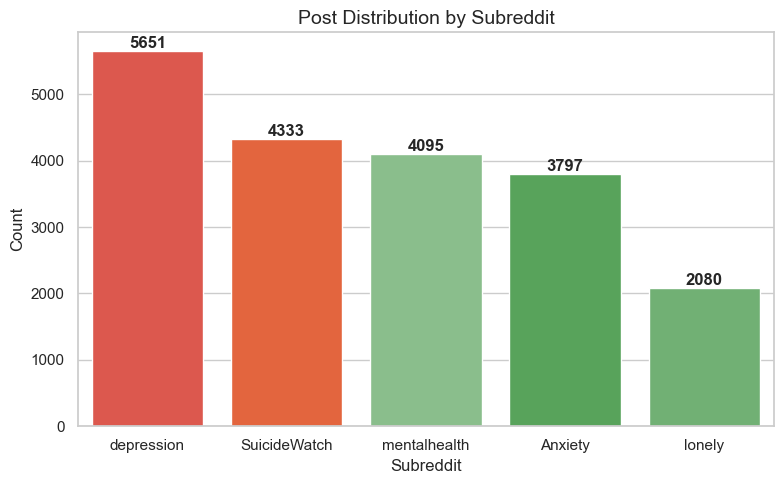

Risk (1) subreddits:   depression, SuicideWatch
Control (0) subreddits: Anxiety, lonely, mentalhealth


In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x="subreddit", order=df["subreddit"].value_counts().index,
              palette={"depression": "#F44336", "SuicideWatch": "#FF5722",
                       "Anxiety": "#4CAF50", "lonely": "#66BB6A", "mentalhealth": "#81C784"},
              ax=ax)
plt.title("Post Distribution by Subreddit", fontsize=14)
ax.set_xlabel("Subreddit")
ax.set_ylabel("Count")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom", fontweight="bold")
plt.tight_layout()
plt.show()

print("Risk (1) subreddits:   depression, SuicideWatch")
print("Control (0) subreddits: Anxiety, lonely, mentalhealth")

## 4. Text Length Analysis

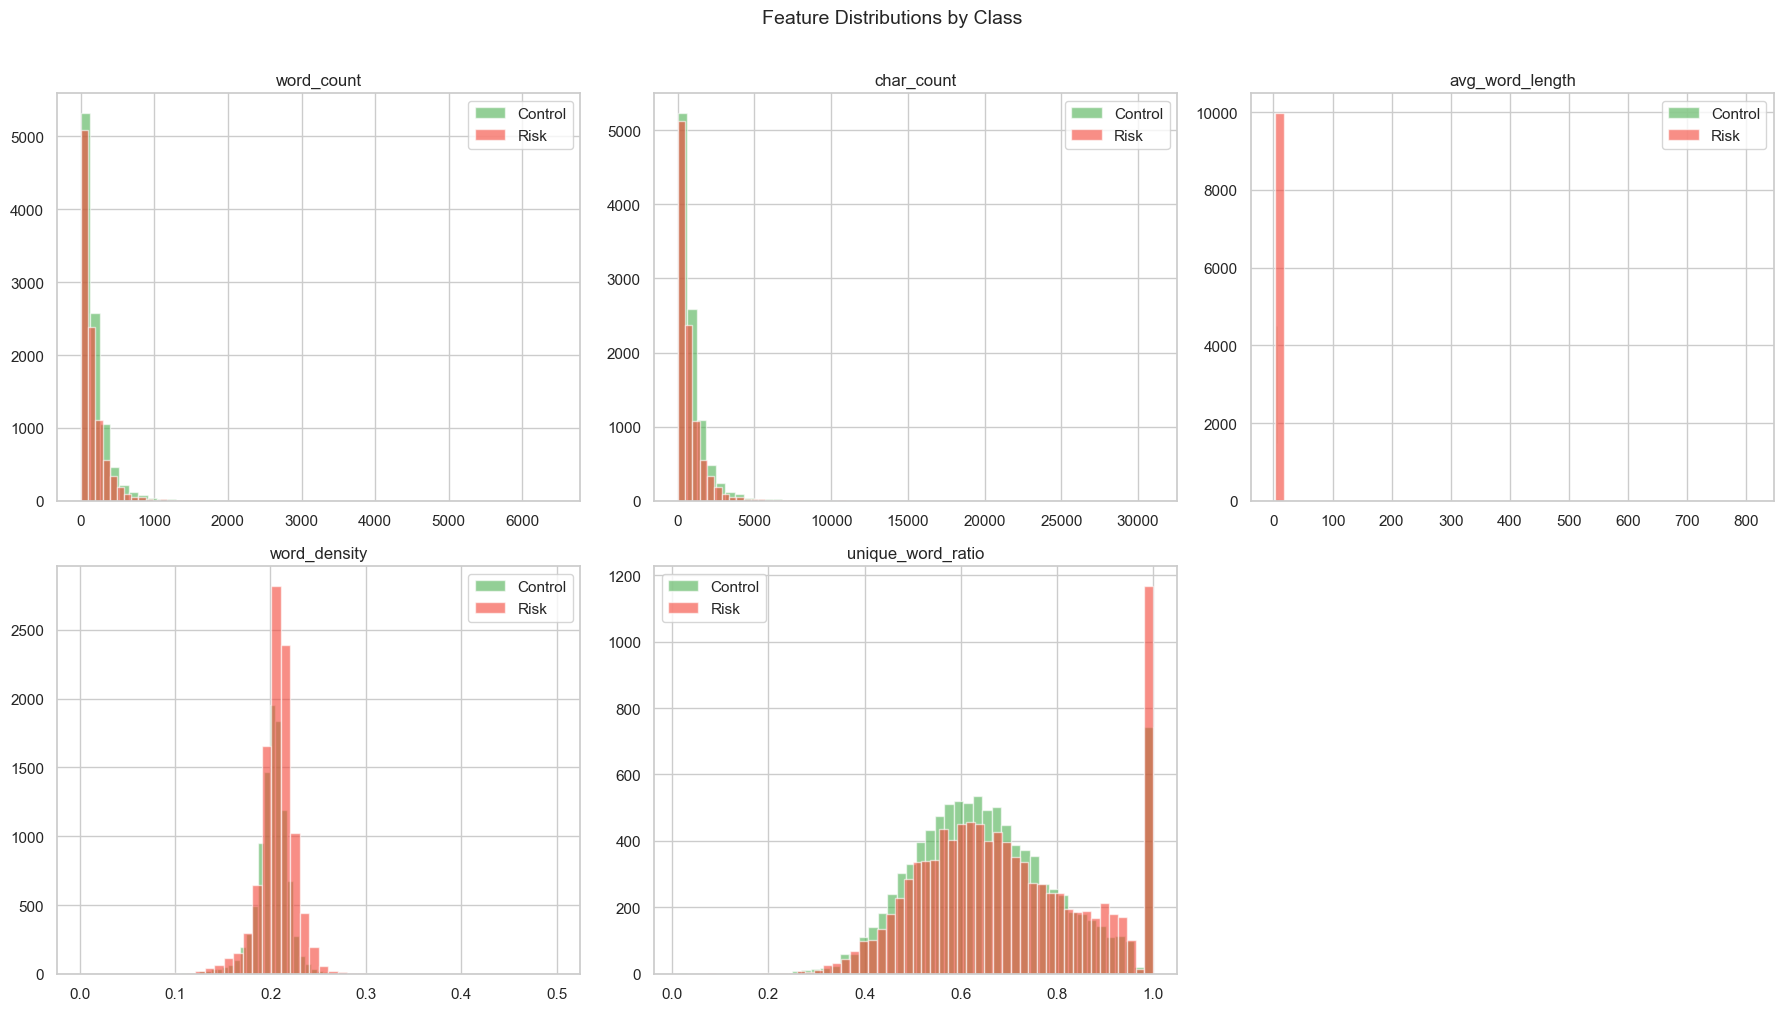

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ["word_count", "char_count", "avg_word_length", "word_density", "unique_word_ratio"]
labels_map = {0: "Control", 1: "Risk"}
colors = {0: "#4CAF50", 1: "#F44336"}

for i, feat in enumerate(features):
    ax = axes[i // 3][i % 3]
    for lab in [0, 1]:
        subset = df[df["label"] == lab][feat]
        ax.hist(subset, bins=50, alpha=0.6, label=labels_map[lab], color=colors[lab])
    ax.set_title(feat, fontsize=12)
    ax.legend()

# Remove empty subplot
axes[1][2].set_visible(False)
plt.suptitle("Feature Distributions by Class", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 5. Word Clouds

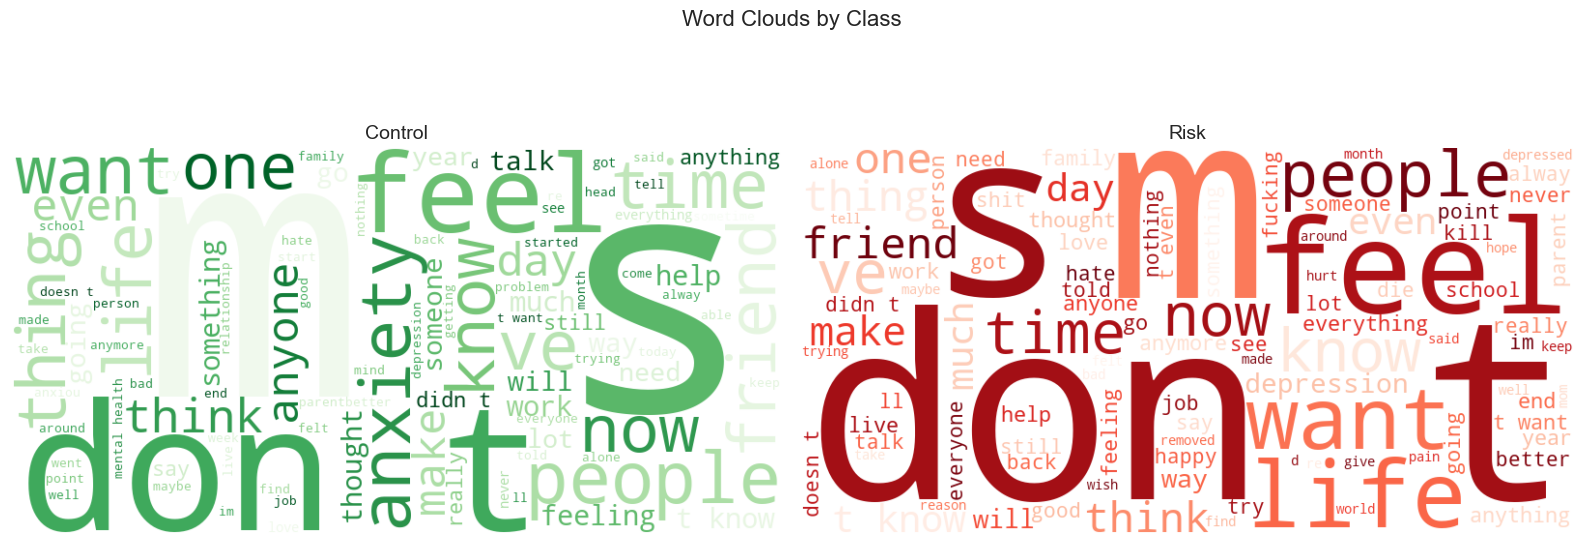

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (lab, title, cmap) in enumerate([(0, "Control", "Greens"), (1, "Risk", "Reds")]):
    text_blob = " ".join(df[df["label"] == lab]["text"].dropna())
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap=cmap, max_words=100).generate(text_blob)
    axes[idx].imshow(wc, interpolation="bilinear")
    axes[idx].set_title(title, fontsize=14)
    axes[idx].axis("off")

plt.suptitle("Word Clouds by Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Top TF-IDF Terms per Class

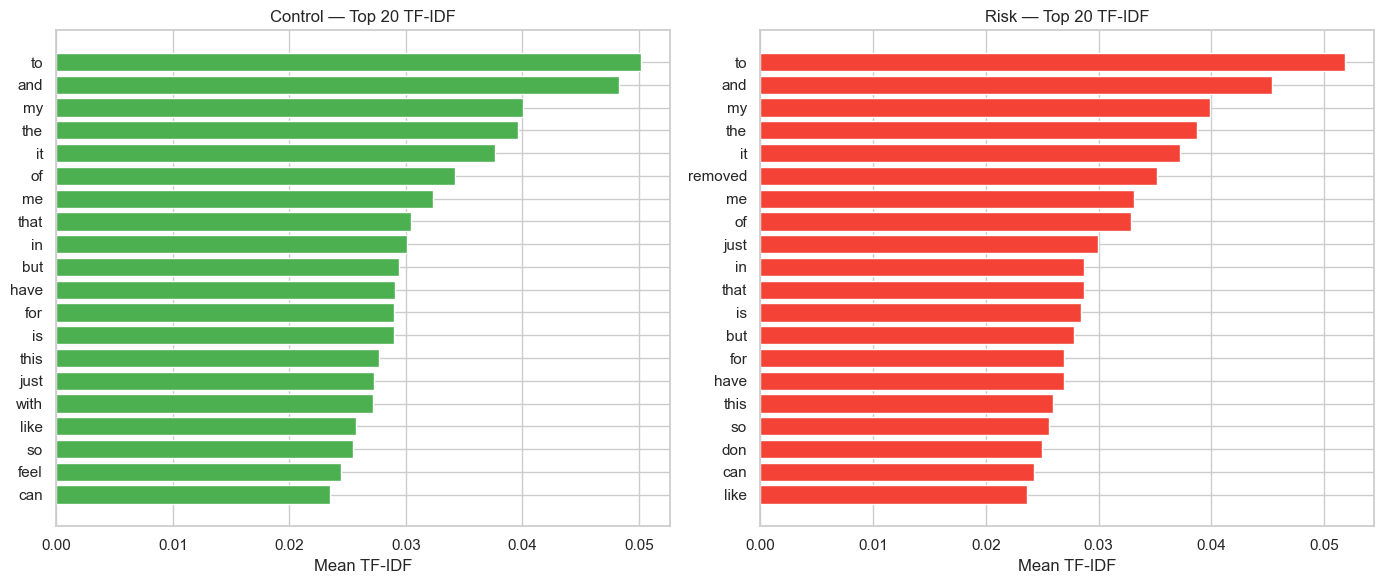

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (lab, title, color) in enumerate([(0, "Control — Top 20 TF-IDF", "#4CAF50"),
                                            (1, "Risk — Top 20 TF-IDF", "#F44336")]):
    subset_texts = df[df["label"] == lab]["text"]
    vec, X = build_tfidf(subset_texts, max_features=5000)
    mean_tfidf = X.mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[-20:]
    words = np.array(vec.get_feature_names_out())[top_idx]
    scores = mean_tfidf[top_idx]

    axes[idx].barh(words, scores, color=color)
    axes[idx].set_title(title, fontsize=12)
    axes[idx].set_xlabel("Mean TF-IDF")

plt.tight_layout()
plt.show()

## 7. Feature Correlations

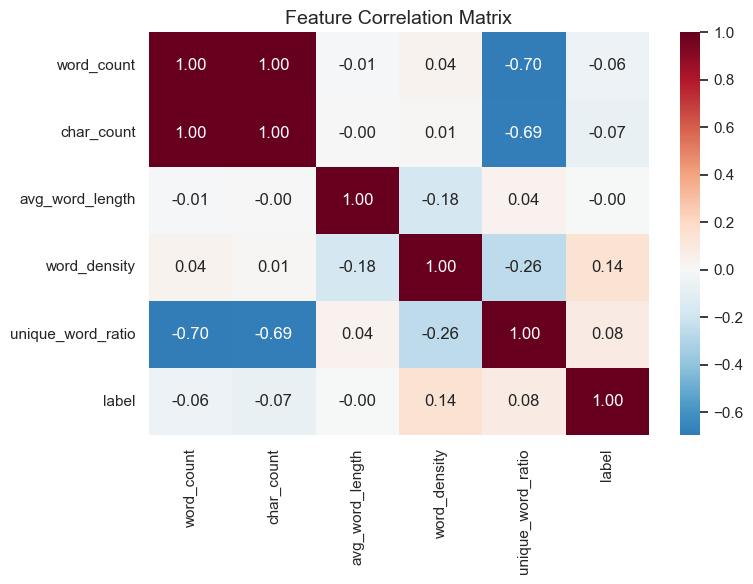

In [10]:
numeric_cols = ["word_count", "char_count", "avg_word_length", "word_density", "unique_word_ratio", "label"]
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
ax.set_title("Feature Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Summary Statistics by Class

In [11]:
summary = df.groupby("label")[["word_count", "char_count", "avg_word_length",
                               "word_density", "unique_word_ratio"]].agg(["mean", "median", "std"])
summary.columns = ["_".join(c) for c in summary.columns]
summary

,word_count_mean,word_count_median,word_count_std,char_count_mean,char_count_median,char_count_std,avg_word_length_mean,avg_word_length_median,avg_word_length_std,word_density_mean,word_density_median,word_density_std,unique_word_ratio_mean,unique_word_ratio_median,unique_word_ratio_std
label,,,,,,,,,,,,,,,
0,180.328720,120.0,221.381909,890.746791,587.0,1098.297221,5.002689,4.925061,0.526449,0.201594,0.203043,0.017178,0.667728,0.647356,0.161624
1,154.897135,95.0,205.651653,748.317007,459.0,1003.034278,4.973911,4.808895,8.100599,0.206932,0.207948,0.019701,0.695836,0.670588,0.174607


## 9. Save Processed Data

In [12]:
save_processed(df, "../data/processed/primary_clean.csv")
print("Columns saved:", list(df.columns))
print("EDA done.")

Saved 19956 rows -> ../data/processed/primary_clean.csv
Columns saved: ['text', 'label', 'subreddit', 'word_count', 'char_count', 'avg_word_length', 'word_density', 'unique_word_ratio']
EDA done.


## 10. Feature Engineering Ideas

Beyond word-level TF-IDF, several feature directions emerged from the EDA:

| Feature | Rationale |
|---------|-----------|
| **Word count / char count** | Risk posts tend to be longer — post length is a weak but useful signal |
| **Unique word ratio** | Lower vocabulary diversity could indicate rumination patterns |
| **VADER sentiment scores** | Emotional intensity differs between classes; compound/negative scores could help |
| **TF-IDF (1,2)-grams** | Top terms differ sharply between classes (e.g., "feel", "depressed" vs. neutral topics) |
| **Engagement proxy** | High word-count quartile as an engagement flag — relevant to RQ2 bias testing |

These will be used in Notebook 02 (model training).

C:\Users\Kartik\AppData\Local\Temp\ipykernel_14260\2621646102.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='word_count', data=df, ax=axes[0],
C:\Users\Kartik\AppData\Local\Temp\ipykernel_14260\2621646102.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Control (0)", "Risk (1)"])


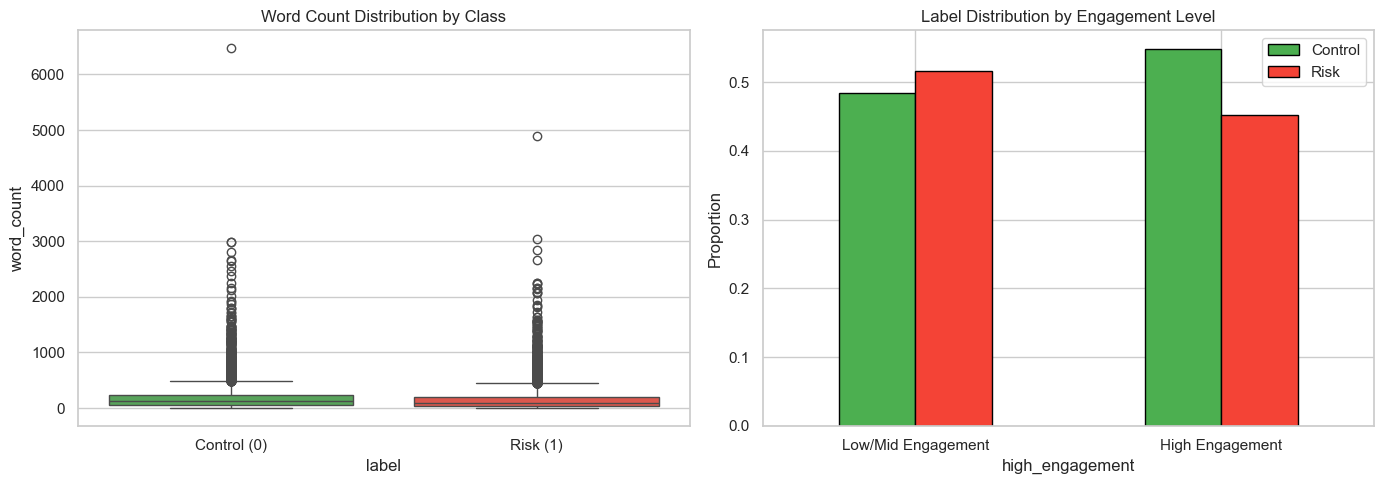

Engagement cross-tabulation (row-normalised):
label                0      1
high_engagement              
False            0.484  0.516
True             0.548  0.452


In [13]:
# Engagement proxy: high word-count posts
df['high_engagement'] = df['word_count'] > df['word_count'].quantile(0.75)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(x='label', y='word_count', data=df, ax=axes[0],
            palette=["#4CAF50", "#F44336"])
axes[0].set_title("Word Count Distribution by Class")
axes[0].set_xticklabels(["Control (0)", "Risk (1)"])

# Engagement cross-tab
ct = pd.crosstab(df['high_engagement'], df['label'], normalize='index')
ct.plot(kind='bar', ax=axes[1], color=["#4CAF50", "#F44336"], edgecolor="black")
axes[1].set_title("Label Distribution by Engagement Level")
axes[1].set_xticklabels(["Low/Mid Engagement", "High Engagement"], rotation=0)
axes[1].set_ylabel("Proportion")
axes[1].legend(["Control", "Risk"])

plt.tight_layout()
plt.show()

print("Engagement cross-tabulation (row-normalised):")
print(ct.round(3))

## 11. Baseline Model (Word Count Only)

A quick sanity check: can word count alone predict mental-health risk? This establishes a trivial baseline that the full TF-IDF model (Notebook 02) must beat.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[['word_count']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.38      0.45      1995
           1       0.53      0.71      0.61      1997

    accuracy                           0.54      3992
   macro avg       0.55      0.54      0.53      3992
weighted avg       0.55      0.54      0.53      3992



## 12. Preliminary Findings

1. **Balanced dataset** (~50/50 by construction) — no resampling needed beyond initial balancing
2. **No missing values**; duplicates removed by pipeline
3. **Risk posts tend to be longer** on average — word count is a weak but consistent signal
4. **TF-IDF top terms** differ clearly between classes → baseline TF-IDF + LR should be competitive (RQ1)
5. **Engagement groups** show similar class balance → bias likely minimal (RQ2)
6. **Model relies on many terms**, not just trigger keywords → likely robust (RQ3)

**Limitation:** Subreddit-based labeling may introduce contextual bias, which is evaluated through bias and robustness analysis in later stages.